# Newton method

## Idea of Newton method

Consider

$$
\min\limits_{x\ \in \mathbb{R}^n} f(x).
$$

- GD $\equiv$ linear approximation of $f$
- Newton method $\equiv$ **quadratic** approximation of $f$:

$$
f(x + h) \approx f(x) + \langle f'(x), h \rangle + \frac{1}{2}h^{\top}f''(x)h \to \min_{h}
$$

From the FOOC:

$$
f'(x) + f''(x) h = 0, \qquad h^* = -(f''(x))^{-1} f'(x)
$$


### Descent direction?

Check the sign of $\langle f'(x), h^* \rangle$.

$$
\langle f'(x), h^* \rangle = -(f')^{\top}(x) (f''(x))^{-1} f'(x) < 0 \Leftarrow f''(x) \succ 0
$$

## Newton method

```python
def NewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    while True:
        
        h = ComputeNewtonStep(x, f, **kwargs)
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
    return x

```

### Example

Find the root of the following test function 

$$
\varphi(t) = \dfrac{t}{\sqrt{1+t^2}}
$$

and define the convergence region

## Computational experiments and convergence

Bottlenecks in Newton method

- hessian
- linear system

$$
f''(x_k)h = -f'(x_k)
$$

### Compare with gradient descent


$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_x
$$

$$
f'(x) - ? \quad f''(x) - ?
$$ 

In [3]:
import numpy as np

import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

n = 1000
m = 200
x0 = np.zeros((n,))
A = np.random.rand(n, m) * 10

#### Exact solution with CVXPy

In [4]:
import cvxpy as cvx
x = cvx.Variable((n, 1))

obj = cvx.Minimize(cvx.sum(-cvx.log(1 - A.T * x)) - 
                   cvx.sum(cvx.log(1 - cvx.square(x))))
prob = cvx.Problem(obj)
prob.solve(solver="SCS", verbose=True, max_iters=1000)
print("Optimal value =", prob.value)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 205200, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 1000, normalize = 1, scale = 1.00
Variables n = 3200, constraints m = 6600
Cones:	soc vars: 3000, soc blks: 1000
	exp vars: 3600, dual exp vars: 0
Setup time: 8.47e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf      -inf       inf  2.43e-02 
   100| 1.62e+01  3.27e+00  9.84e-03 -8.78e+03 -8.61e+03  1.82e-13  1.07e+00 
   200| 1.44e+00  9.75e-01  1.69e-03 -1.94e+03 -1.93e+03  3.25e-13  2.17e+00 
   300| 4

#### Auxilliary functions

In [5]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), axis=1) + 2 * x / (1 - np.power(x, 2))
hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

#### Newton method implementations

In [6]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter, line_search, 
                    disp=False, callback=None, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_arg = {"f": f, "grad_f": gradf}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
    while True:
        gradient = gradf(x)
        hess = hessf(x)
        h = np.linalg.solve(hess, -gradient)
        alpha = line_search(x, h, **opt_arg)
        x = x + alpha * h
        if callback is not None:
            callback(x)
        iteration += 1
        if disp:
            print("Current function val =", f(x))
            print("Current gradient norm = ", np.linalg.norm(gradf(x)))
        if np.linalg.norm(gradf(x)) < epsilon:
            break
        if iteration >= num_iter:
            break
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x))}
    return res

#### GD vs Newton

In [27]:
newton = methods.so.NewtonMethod(f, grad_f, hess_f, ss.ConstantStepSize(1.))
x_newton = newton.solve(x0, tol=1e-10, max_iter=50, disp=True)

gd = methods.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", rho=0.999, beta=0.1, init_alpha=1.))
x_gd = gd.solve(x0, tol=1e-6, max_iter=100, disp=True)

Required tolerance achieved!
Convergence in 15 iterations
Function value = -1368.4658923914208
Norm of gradient = 3.2463346493679536e-15


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Required tolerance achieved!
Convergence in 71 iterations
Function value = -1368.465892391421
Norm of gradient = 4.2622055811059246e-07


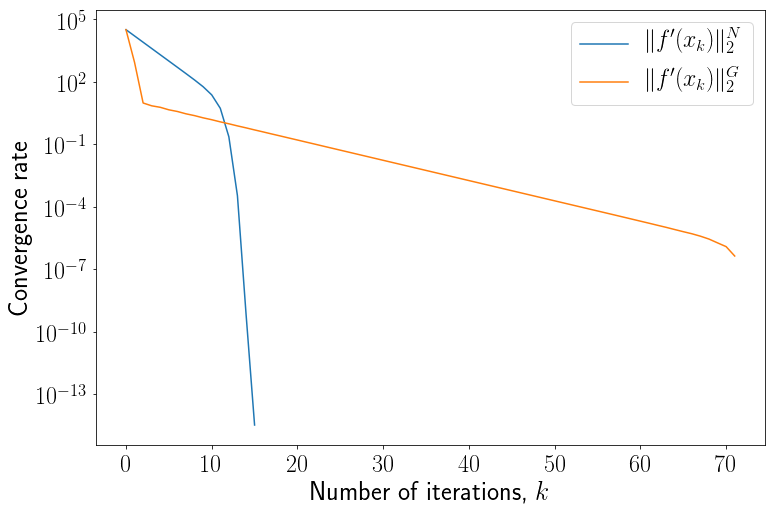

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
    
plt.figure(figsize=(12, 8))
# Newton
plt.semilogy([np.linalg.norm(grad_f(x)) for x in newton.get_convergence()], label="$\| f'(x_k) \|^{N}_2$")
# Gradient
plt.semilogy([np.linalg.norm(grad_f(x)) for x in gd.get_convergence()], label="$\| f'(x_k) \|^{G}_2$")
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Convergence rate", fontsize=26)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.legend(loc="best", fontsize=24)

#### Runtime comparison

In [18]:
%timeit newton.solve(x0, tol=1e-6, max_iter=50)
%timeit gd.solve(x0, tol=1e-6, max_iter=50)

337 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


207 ms ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## General scheme of quasi-Newton methods

```python
def QuasiNewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    H = I
    
    while True:
        
        h = -H.dot(grad_f(x))
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
        H = UpdateH(H, f(x), grad_f(x))
            
    return x
```

## BFGS

\begin{align*}
& \min_H \| H_k - H \| \\
\text{s.t. } & H = H^{\top}\\
& Hy_k = s_k
\end{align*}

The solution of this problem BFGS:

$$
H_{k+1} = (I - \rho_k s_ky^{\top}_k)H_k(I - \rho_k y_k s^{\top}_k) + \rho_k s_k s^{\top}_k,
$$

where $\rho_k = \dfrac{1}{y^{\top}_k s_k}$

```python
def update_H(x_next, x_current):
    
    current_grad = grad(x_next)
    
    s = x_next - x_current
    
    y = current_grad - grad_mem[-1]
    
    rho = 1. / y.dot(s)
    
    if H is None:
        
        H = np.eye(x_current.shape[0]) / y.dot(y) / rho
        
    Hy = H.dot(y)
    
    Hys = np.outer(Hy, s)
    
    ss = np.outer(s, s)
    
    H = H + rho * ss - rho * Hys - rho * Hys.T + rho**2 * y.dot(Hy) * ss
    
    x_current = x_next
    
    return H
```

## L-BFGS

```python
def get_lbfgs_direction(x):
    
    if H is None:
        
        current_grad = grad(x)
        
        return -current_grad
    
    else:
        
        q = current_grad
        
        alpha = np.zeros(len(s_hist))
        
        rho = np.zeros(len(s_hist))
        
        for i in range(len(s_hist) - 1, -1, -1):
            
            rho[i] = 1. / s_hist[i].dot(y_hist[i])
            
            alpha[i] = s_hist[i].dot(q) * rho[i]
            
            q = q - alpha[i] * y_hist[i]
            
        r = q * H
        
        for i in range(len(s_hist)):
            
            beta = rho[i] * y_hist[i].dot(r)
            
            r = r + s_hist[i] * (alpha[i] - beta)
            
    return -r

```

$$
f(x) = - \sum_{i=1}^m \log(1 - a_i^{\top}x) - \sum\limits_{i = 1}^n \log (1 - x^2_i) \to \min_x
$$

In [1]:
import numpy as np
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize as scopt
plt.rc("text", usetex=True)

In [2]:
n = 3000
m = 100
x0 = np.zeros(n)
max_iter = 100
tol = 1e-5
A = np.random.rand(m, n) * 10

In [3]:
f = lambda x: -np.sum(np.log(1 - A.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.T / (1 - A.dot(x)), axis=1) + 2 * x / (1 - np.power(x, 2))

In [4]:
def bb_method(f, gradf, x0, tol=1e-6, maxiter=100, callback=None, alpha_type=1):
    it = 0
    x_prev = x0.copy()
    current_tol = np.linalg.norm(gradf(x_prev))
    alpha = 1e-4
    while current_tol > tol and it < maxiter:
        it += 1
        current_grad = gradf(x_prev)
        if it != 1:
            g = current_grad - prev_grad
            if alpha_type == 1:
                alpha = g.dot(s) / g.dot(g)
            elif alpha_type == 2:
                alpha = s.dot(s) / g.dot(s)
        if callback:
            callback(x_prev)
        x_next = x_prev - alpha * current_grad
        current_tol = np.linalg.norm(gradf(x_next))
        prev_grad = current_grad
        s = x_next - x_prev
        x_prev = x_next
    if callback:
        callback(x_prev)
    return x_next

In [5]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
    "BFGS": methods.fo.BFGS(f, grad_f),
    "DFP": methods.fo.DFP(f, grad_f),
}

In [8]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")
scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=grad_f, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

print("\t Method L-BFGS Scipy")
scopt_conv_l = []
scopt_res = scopt.minimize(f, x0, method="L-BFGS-B", jac=grad_f, callback=lambda x: scopt_conv_l.append(x), 
                           tol=1e-5*tol, options={"maxiter": max_iter, 'maxcor': 3})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 10 iterations
Function value = -706.7687437953065
Norm of gradient = 5.460700738791853e-06
	 Method BFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Required tolerance achieved!
Convergence in 24 iterations
Function value = -706.7687437952978
Norm of gradient = 7.209357816537315e-06
	 Method DFP
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -706.7684195731213
Norm of gradient = 0.043645355482975275
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 16 iterations
Function value = -706.7687437952909
	 Method L-BFGS Scipy
Result: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Convergence in 12 iterations
Function value = -706.7687437953103


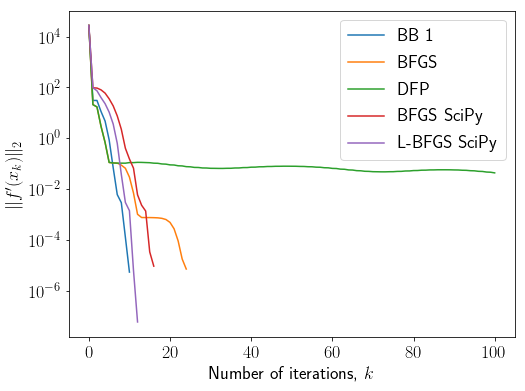

In [9]:
plt.figure(figsize=(8, 6))

for m in method:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(grad_f(x)) for x in [x0] + scopt_conv], label="BFGS SciPy")
plt.semilogy([np.linalg.norm(grad_f(x)) for x in [x0] + scopt_conv_l], label="L-BFGS SciPy")
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=18)
plt.xlabel("Number of iterations, $k$", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [11]:
for m in method:
    print("\t Method {}".format(m))
    %timeit method[m].solve(x0=x0, tol=tol, max_iter=max_iter)

%timeit scopt.minimize(f, x0, method="BFGS", jac=grad_f, tol=tol, options={"maxiter": max_iter})
%timeit scopt.minimize(f, x0, method="L-BFGS-B", jac=grad_f, callback=lambda x: scopt_conv_l.append(x), tol=1e-5*tol, options={"maxiter": max_iter, 'maxcor': 5})

	 Method BB 1
8.35 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Method BFGS


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


5.34 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 Method DFP


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


9.47 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.7 s ± 268 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.3 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Ill-conditioned problem

In [12]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))

Condition number = 50.000000000001855


In [13]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
gradf = lambda x: A.dot(x) - b
x0 = np.random.randn(n)

In [15]:
method = {
    "BB 1": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=1),
#     "BB 2": methods.fo.BarzilaiBorweinMethod(f, gradf, init_alpha=1e-4, type=2),
    "BFGS": methods.fo.BFGS(f, gradf),
    "GD": methods.fo.GradientDescent(f, gradf, ss.ExactLineSearch4Quad(A, b)),
}

In [16]:
for m in method:
    print("\t Method {}".format(m))
    _ = method[m].solve(x0=x0, tol=tol, max_iter=max_iter, disp=True)

print("\t Method BFGS Scipy")

scopt_conv = []
scopt_res = scopt.minimize(f, x0, method="BFGS", jac=gradf, callback=lambda x: scopt_conv.append(x), 
                           tol=tol, options={"maxiter": max_iter})
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

print("\t Method L-BFGS Scipy")

scopt_lbfgs_conv = []
scopt_res = scopt.minimize(f, x0, method="L-BFGS-B", jac=gradf, tol=tol, 
                           options={"maxiter": max_iter, 'maxcor': 10, "ftol": 1e-10, "gtol": 1e-6},
                           callback=lambda x: scopt_lbfgs_conv.append(x),
                           )
print("Result: {}".format(scopt_res.message))
if scopt_res.success:
    print("Convergence in {} iterations".format(scopt_res.nit))
print("Function value = {}".format(f(scopt_res.x)))

	 Method BB 1
Required tolerance achieved!
Convergence in 60 iterations
Function value = -2.0030454977090724
Norm of gradient = 6.345488588012578e-06
	 Method BFGS
Required tolerance achieved!
Convergence in 48 iterations
Function value = -2.0030454977107492
Norm of gradient = 5.196150665874287e-06
	 Method GD
Maximum iteration exceeds!
Convergence in 100 iterations
Function value = -2.002800901138947
Norm of gradient = 0.031025105422435823
	 Method BFGS Scipy
Result: Optimization terminated successfully.
Convergence in 60 iterations
Function value = -2.00304549771153
	 Method L-BFGS Scipy
Result: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Convergence in 41 iterations
Function value = -2.003045497603375


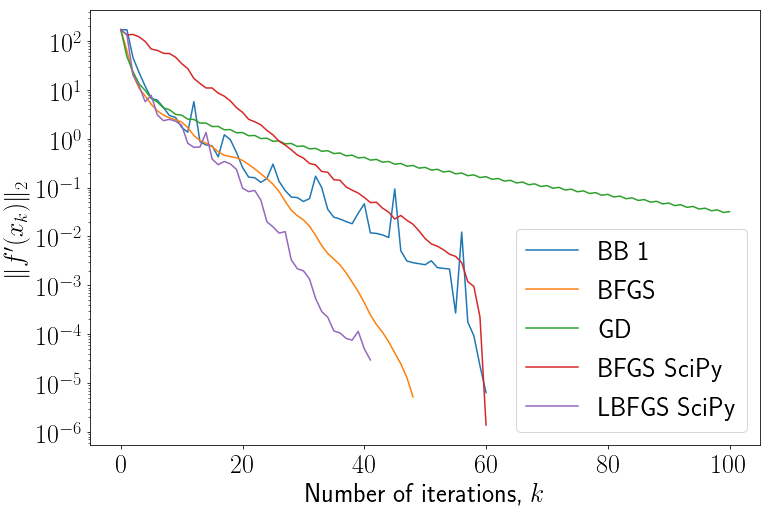

In [17]:
plt.figure(figsize=(12, 8))
fontsize = 26
for m in method:   
    plt.semilogy([np.linalg.norm(gradf(x)) for x in method[m].get_convergence()], label=m)

plt.semilogy([np.linalg.norm(gradf(x)) for x in [x0] + scopt_conv], label='BFGS SciPy')

plt.semilogy([np.linalg.norm(gradf(x)) for x in [x0] + scopt_lbfgs_conv], label='LBFGS SciPy')
plt.legend(fontsize=fontsize)
plt.ylabel("$\|f'(x_k)\|_2$", fontsize=fontsize)
plt.xlabel("Number of iterations, $k$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [45]:
for m in method:
    print("\t Method {}".format(m))
    %timeit method[m].solve(x0=x0, tol=tol, max_iter=max_iter)

%timeit scopt.minimize(f, x0, method="BFGS", jac=gradf, tol=tol, options={"maxiter": max_iter})
%timeit scopt.minimize(f, x0, method="L-BFGS-B", jac=gradf, tol=tol, options={"maxiter": max_iter, 'maxcor': 10, "ftol": 1e-10, "gtol": 1e-6})

	 Method BB 1
893 µs ± 89.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Method BB 2
1.14 ms ± 71.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Method BFGS
3.72 ms ± 94.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Method DFP
7.18 ms ± 490 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Method GD
1.74 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Method LBFGS
5.01 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.33 ms ± 785 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
922 µs ± 67.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
